In [2]:
# The -Uqq just suppresses the messages.
# !pip install fastai fastcore -Uqq --upgrade 
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastbook/__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [4]:
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *

In [6]:
key = os.environ.get('AZURE_SEARCH_KEY', '3a8925a009c946e2b2ada0ba0991a4fd')

In [7]:
results = search_images_bing(key, 'new zealand kea bird')
ims = results.attrgot('contentUrl')
len(ims)

150

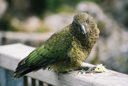

In [8]:
dest = 'images/test.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
bird_types = ['kea', 'tui']
path = Path('birds')

if not path.exists():
    path.mkdir()
    for b in bird_types:
        dest = (path/b)
        dest.mkdir(exist_ok = True)
        results = search_images_bing(key, f"New Zealand {b} bird")
        download_images(dest, urls = results.attrgot('contentUrl'))

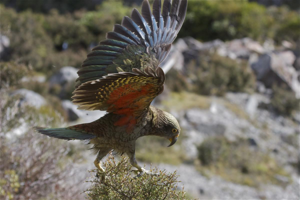

In [10]:
# Open the first image that was saved and show a thumbnail of the image
Image.open((path/'kea').ls()[0]).to_thumb(300, 300)

In [11]:
# Remove any bad files
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#1) [None]

In [12]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = birds.dataloaders(path)

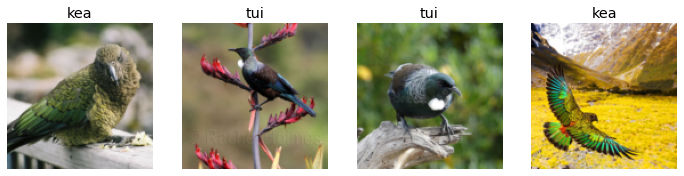

In [13]:
dls.valid.show_batch(max_n = 4, nrows = 1)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


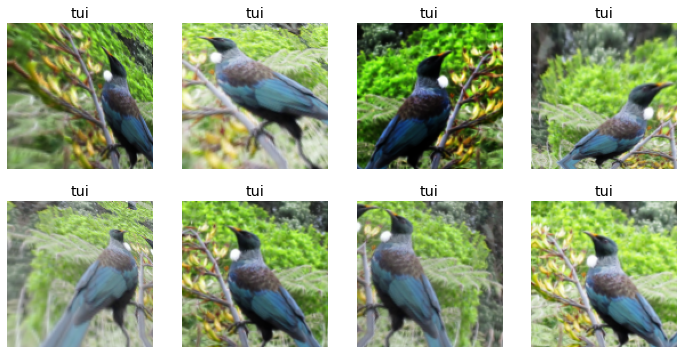

In [14]:
birds = birds.new(item_tfms=Resize(128), batch_tfms = aug_transforms(mult=2))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n = 8, nrows = 2, unique = True)

In [15]:
# Create a new datablock and dataloader which uses data augmentation to beef up the dataset
birds = birds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = birds.dataloaders(path)

In [16]:
# Create a conv net learner based on the resnet18 architecture
learner = cnn_learner(dls, resnet18, metrics = error_rate)

# Use transfer learning to fine tune the dataset on 4 epochs of the data
learner.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.928808,0.073447,0.000000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.214480,0.036304,0.000000,00:08
1,0.144054,0.016979,0.000000,00:09
2,0.121081,0.012481,0.000000,00:09
3,0.091613,0.006271,0.000000,00:08


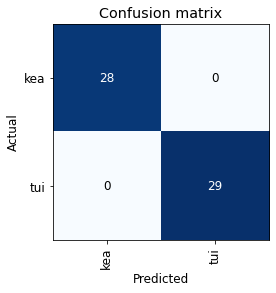

In [17]:
# Test the performance of the model on the validation dataset
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

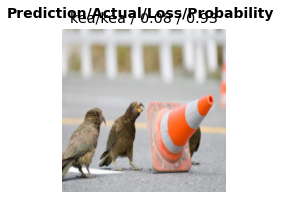

In [18]:
interp.plot_top_losses(1, nrows = 1)

In [20]:
learner.export('kea_v_tui.pkl')